# Import Libraries

In [101]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from pylab import rcParams

# matplotlib.use("Qt5Agg")
import missingno as msno
from datetime import date

# Plotly Express - Plotly - cufflinks 
# --------------------------------------
'''
Cufflink is also a python library that connects plotly
with pandas so that we can create charts directly on data frames.
{It basically acts as a plugin.}
'''
import cufflinks as cf
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

# Metrics 
# --------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report
from sklearn.neighbors import LocalOutlierFactor


# Machine Learning Models 
# --------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Customize to Remove Warnings and Better Observation  
# ------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 600)
from termcolor import colored
constraints = ['#581845', '#C70039']
metric_constraints = ['#2ECC71','#34495E','#D0D3D4']
cat_feat_constraints = ['#7FB3D5','#76D7C4','#F7DC6F','#85929E','#283747']

# Load and Check Data

In [102]:
df = pd.read_csv("datasets/hitters.csv")

In [103]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(df, head=5):

    print("Info".center(60, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(60, '~'))
    print(df.head(head))
    print("Unique Values".center(60, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(60, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(60, '~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(60, '~'))
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    fl

In [104]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes !=
                   "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes ==
                   "O" and df[col].nunique() > car_th]

    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float", "int32", "float32", "int64",
                                                                "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")

    print("".center(60, '~'))
    print(f'cat_cols: {cat_cols}')
    print(f'cat_cols len: {len(cat_cols)}')
    print("".center(60, '~'))

    print(f'num_cols: {num_cols}')
    print(f'num_cols len: {len(num_cols)}')
    print("".center(60, '~'))

    print(f'cat_but_car: {cat_but_car}')
    print(f'cat_but_car len: {len(cat_but_car)}')
    print("".center(60, '~'))

    print(f'num_but_cat: {num_but_cat}')
    print(f'num_but_cat len: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 322
Variables: 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols: ['League', 'Division', 'NewLeague']
cat_cols len: 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'Salary']
num_cols len: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car: []
cat_but_car len: 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_but_cat: []
num_but_cat len: 0


In [105]:
def check_classes(df):  
    dict = {}
    for i in list(df.columns):
        dict[i] = df[i].value_counts().shape[0]

    unq = pd.DataFrame(dict,index=["Unique Count"]).transpose().sort_values(by="Unique Count", ascending=False)
    return unq

check_classes(df)

,Unique Count
CAtBat,314
CHits,288
CRBI,262
CRuns,261
CWalks,248
AtBat,247
PutOuts,232
Assists,161
Salary,150
CHmRun,146


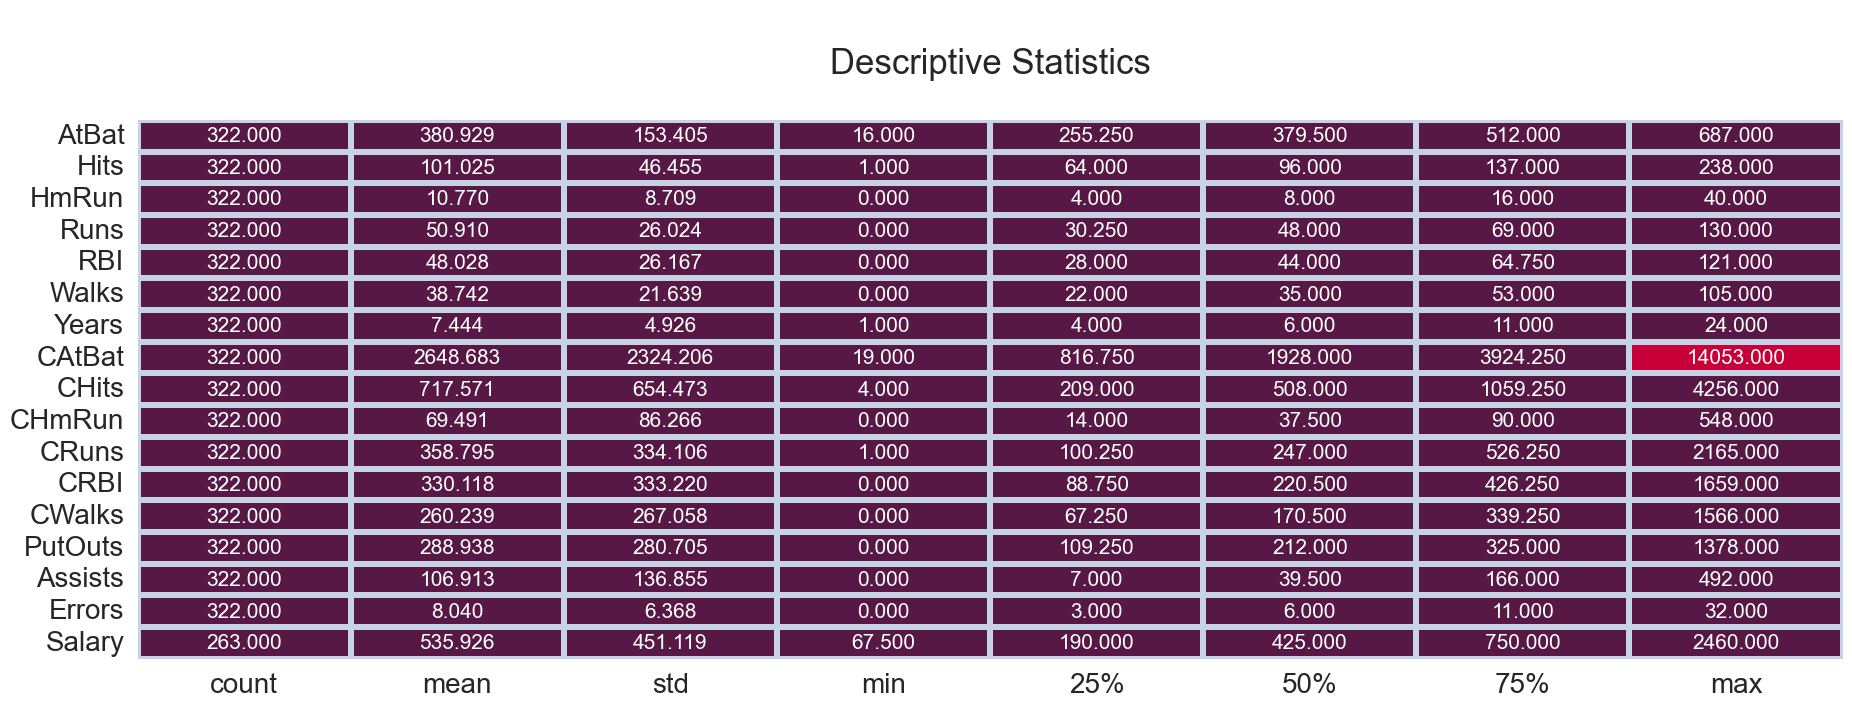

In [106]:
def descriptive_statistics(df):
    describe_ = df.describe().T
    describe_df = pd.DataFrame(index=df.columns,
                               columns=describe_.columns,
                               data=describe_)

    f, ax = plt.subplots(figsize=(22,7))
    sns.heatmap(describe_df,
                annot=True,
                cmap= constraints,
                fmt='.3f',
                ax=ax,
                linecolor='#C6D3E5',
                linewidths=3,
                cbar=False,
                annot_kws={"size": 15})
    plt.xticks(size=20)
    plt.yticks(size=20,
               rotation=0)
    plt.title("\nDescriptive Statistics\n", size=25)
    plt.show()


num_desc = df[num_cols]
descriptive_statistics(num_desc)

# Exploratory Data Analysis

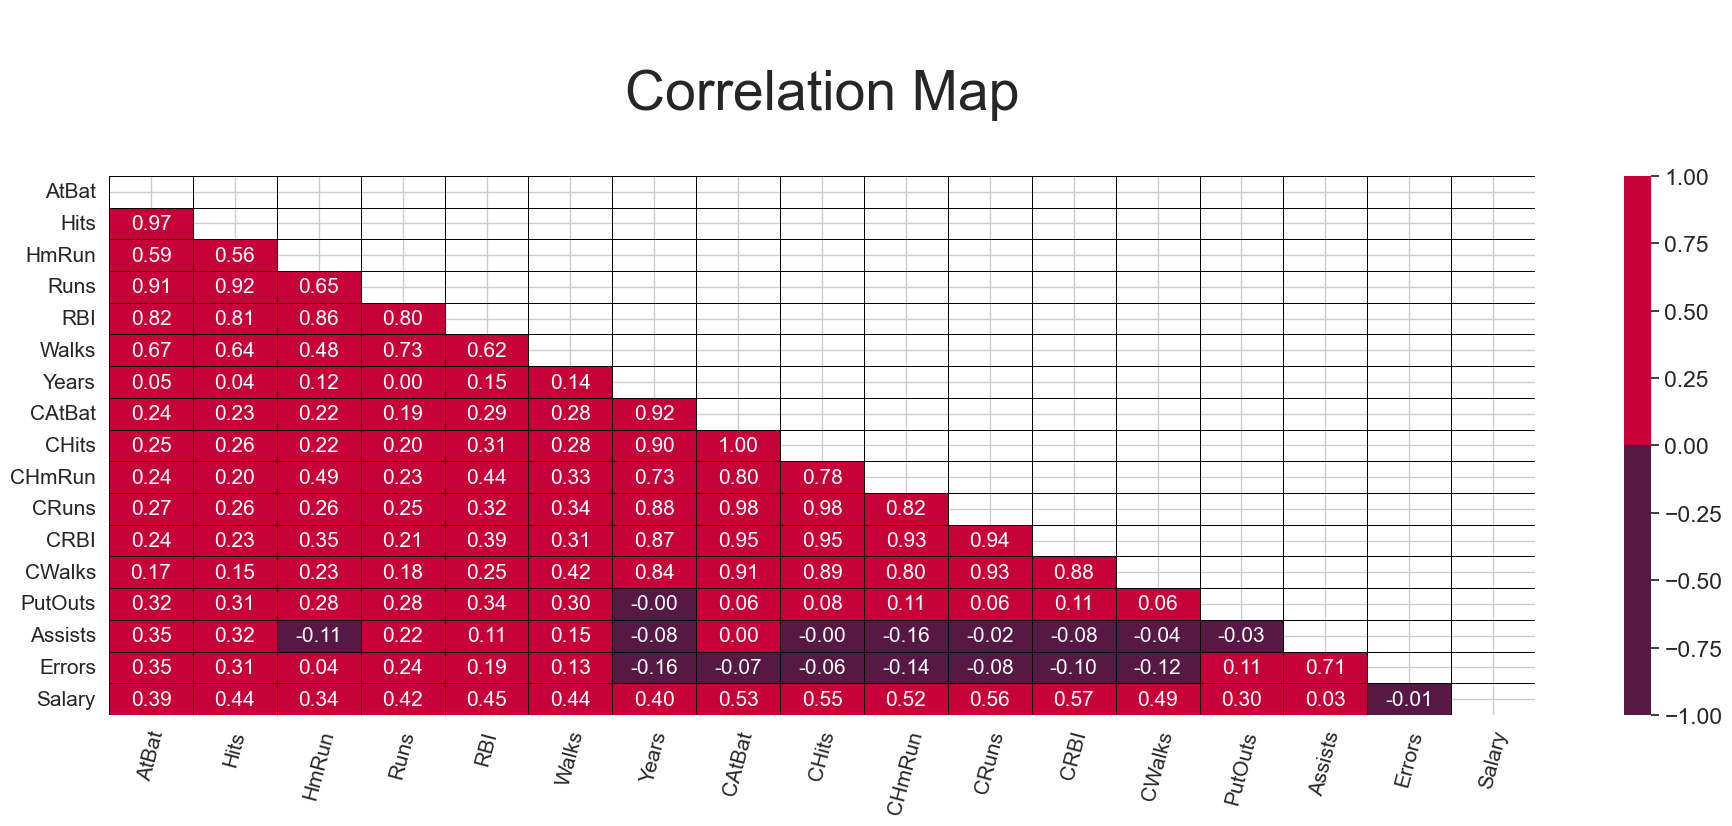

In [107]:
def corr_map(df,width=23, height=7):
    mtx = np.triu(df[num_cols].corr())
    f,ax=plt.subplots(figsize = (width,height))
    sns.heatmap(df[num_cols].corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = constraints,
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                annot_kws={"size": 15})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 40)
    plt.show()
    
corr_map(df)

# Analysis of Numerical Features

In [108]:
def num_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Quantiles', 'Distribution'))

    fig.add_trace(go.Box(y=df[column_name],
                         name=str(column_name),
                         showlegend=False,
                         marker_color=constraints[1]),
                  row=1, col=1)

    fig.add_trace(go.Histogram(x=df[column_name],
                               xbins=dict(start=df[column_name].min(),
                                          end=df[column_name].max()),
                               showlegend=False,
                               name=str(column_name),
                               marker=dict(color=constraints[0],
                                           line=dict(color='#DBE6EC',
                                                     width=1))),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


i = 0
for column_name in num_cols:
    i = i + 1
    num_summary(df, column_name)

In [109]:
# # Numerik değişken analizi
# def num_summary(df, numerical_col, plot=False):
#     quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
#     print(df[numerical_col].describe(quantiles).T)

#     if plot:
#         plt.figure(figsize=(10, 5))
#         df[numerical_col].hist(bins=20)
#         plt.xlabel(numerical_col)
#         plt.title(numerical_col)
#         plt.show()

# for col in num_cols:
#     num_summary(df, col, plot=True)

# Analysis of Categorical Features

In [110]:
def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=cat_feat_constraints,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=cat_feat_constraints)),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

for col in cat_cols:
    categorical_variable_summary(df, col)

In [111]:
# def cat_summary(df, col_name, plot=False):
#     print(pd.DataFrame({col_name: df[col_name].value_counts(),
#                         "Ratio": 100 * df[col_name].value_counts() / len(df)}))
#     print("##########################################")
#     if plot:
#         plt.figure(figsize=(10, 5))
#         sns.countplot(x=df[col_name], data=df)
#         plt.show()


# for col in cat_cols:
#     cat_summary(df, col, plot=True)


In [112]:
# Kategorik değişkenlerin target değişkene göre analizi
def target_summary_with_cat(df, target, categorical_col):
    print(pd.DataFrame({"Target_Mean": df.groupby(categorical_col)[target].mean(),
                        "Count": df[categorical_col].value_counts(),
                        "Ratio": 100 * df[categorical_col].value_counts() / len(df)}))
    print("#" * 50)

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        Target_Mean  Count    Ratio
League                             
A         541.99955    175 54.34783
N         529.11750    147 45.65217
##################################################
          Target_Mean  Count    Ratio
Division                             
E           624.27136    157 48.75776
W           450.87687    165 51.24224
##################################################
           Target_Mean  Count    Ratio
NewLeague                             
A            537.11303    176 54.65839
N            534.55385    146 45.34161
##################################################


In [113]:
# Numerik değişkenlerin target değişkenine göre analizi

def target_summary_with_num(df, target, numerical_col):
    print(df.groupby(target).agg({numerical_col: "mean"}))
    print("#" * 50)


for col in num_cols:
    target_summary_with_num(df, "Salary", col)

               AtBat
Salary              
67.50000   181.00000
68.00000   209.00000
70.00000   248.60000
75.00000   236.40000
80.00000   399.00000
...              ...
1940.00000 514.00000
1975.00000 677.00000
2127.33300  20.00000
2412.50000 618.00000
2460.00000 495.00000

[150 rows x 1 columns]
##################################################
                Hits
Salary              
67.50000    41.00000
68.00000    54.00000
70.00000    57.40000
75.00000    58.20000
80.00000   102.00000
...              ...
1940.00000 144.00000
1975.00000 238.00000
2127.33300   1.00000
2412.50000 200.00000
2460.00000 151.00000

[150 rows x 1 columns]
##################################################
              HmRun
Salary             
67.50000    1.00000
68.00000    3.00000
70.00000    3.20000
75.00000    3.00000
80.00000    3.00000
...             ...
1940.00000  0.00000
1975.00000 31.00000
2127.33300  0.00000
2412.50000 20.00000
2460.00000 17.00000

[150 rows x 1 columns]
####################